In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [23]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
# 혹시 코랩환경을 사용하신다면 왼쪽 폴더모양 아이콘을 눌러 "train_data.csv"를 드래그&드롭으로 업로드한 후 사용해주세요
DATA_PATH = '../data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 4.16 s, sys: 292 ms, total: 4.45 s
Wall time: 4.46 s


### 시간별로 정답률이 약간 차이를 보인다.
단순히 시간을 넣지 않고 좀 더 카데고리화해서 넣어볼까?

In [24]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['hour'] = df['Timestamp'].dt.hour
df.groupby('hour')['answerCode'].mean().sort_values()

hour
19    0.528847
20    0.532575
18    0.547598
17    0.553639
16    0.576721
21    0.588505
5     0.624776
6     0.629941
3     0.632685
4     0.633292
2     0.642410
7     0.643050
1     0.644321
22    0.644492
0     0.649446
23    0.659023
8     0.667948
15    0.672702
9     0.682764
14    0.695666
10    0.699632
13    0.704881
11    0.709786
12    0.715727
Name: answerCode, dtype: float64

In [25]:
hg = df.groupby('hour')['answerCode'].mean()

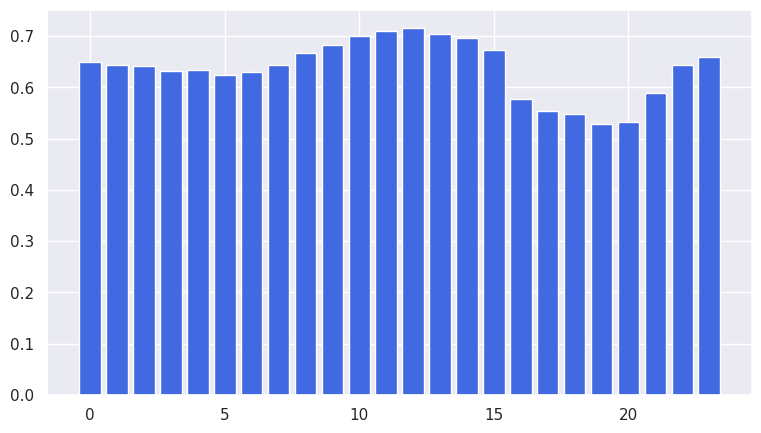

In [26]:
fig = plt.figure(figsize=(20, 5))
ax_basic = fig.add_subplot(1, 2, 1)
ax_basic.bar(hg.index, hg, color='royalblue')
plt.show()

### 요일 별 정답률 차이
0: 월, 6:일
평일 / 주말 차이 있을거라고 생각했는데 별로 없는듯

In [27]:
df['wd'] = df['Timestamp'].dt.weekday
df.groupby('wd')['answerCode'].mean().sort_values()

wd
5    0.603206
2    0.641011
4    0.643362
3    0.658466
1    0.667046
6    0.675257
0    0.676518
Name: answerCode, dtype: float64

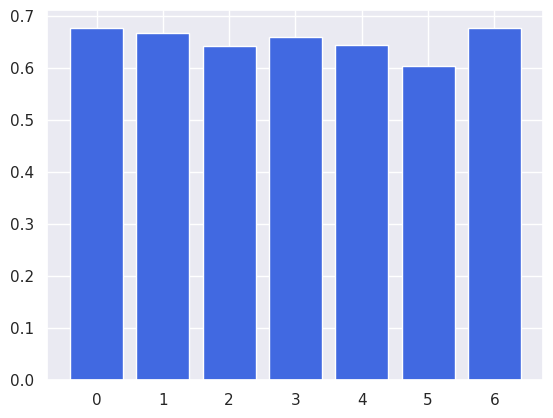

In [28]:
wdf = df.groupby('wd')['answerCode'].mean()
fig = plt.figure()
ax_basic = fig.add_subplot()
ax_basic.bar(wdf.index, wdf, color='royalblue')
plt.show()

### 대분류

In [29]:
df['Bigcat'] = df['testId'].str[2]
df.groupby('Bigcat')['answerCode'].mean().sort_values()

Bigcat
9    0.449948
8    0.502598
7    0.521876
5    0.658208
4    0.684056
3    0.702238
6    0.709232
2    0.737593
1    0.800876
Name: answerCode, dtype: float64

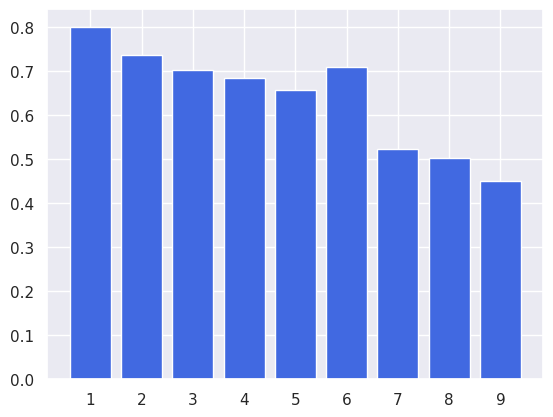

In [30]:
bc =df.groupby('Bigcat')['answerCode'].mean()
fig = plt.figure()
ax_basic = fig.add_subplot()
ax_basic.bar(bc.index, bc, color='royalblue')
plt.show()

### 시험지

In [31]:
df['test_paper'] = df['assessmentItemID'].str[4:7]
tp = df.groupby('test_paper')['answerCode'].mean()
tp.sort_values()

test_paper
057    0.529107
047    0.542518
049    0.550103
051    0.557857
069    0.558188
         ...   
179    0.819098
185    0.831546
195    0.835409
198    0.853838
196    0.895706
Name: answerCode, Length: 198, dtype: float64

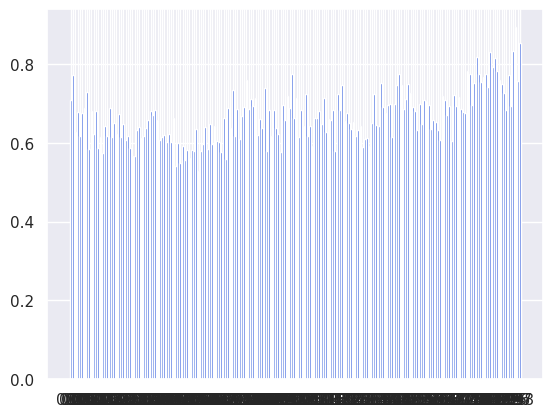

In [32]:
fig = plt.figure()
ax_basic = fig.add_subplot()
ax_basic.bar(tp.index, tp, color='royalblue')
plt.show()

In [33]:
### 문제 번호
df['problem_id'] = df['assessmentItemID'].str[-3:]
tem = df.groupby('problem_id')['answerCode']
pd.DataFrame({'mean' : tem.mean(), 'cnt':tem.count()}).reset_index()

,problem_id,mean,cnt
0,001,0.749916,371755
1,002,0.720062,370972
2,003,0.687773,371640
3,004,0.663364,369705
4,005,0.599134,360607
5,006,0.555685,197772
6,007,0.515399,127121
7,008,0.457156,67150
8,009,0.481729,18417
9,010,0.527892,5342


### 문항을 푸는 데 걸린 시간과 정답률 사이의 관계

In [34]:
def percentile(s):
    return np.sum(s) / len(s)

In [35]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
df['elapsed'] = diff
elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

In [36]:
df.elapsed.describe()

count    2.266586e+06
mean     5.268592e+04
std      4.046780e+05
min      0.000000e+00
25%      1.300000e+01
50%      3.700000e+01
75%      1.350000e+02
max      2.560230e+07
Name: elapsed, dtype: float64

다음 문제 푸는데 1시간 이상 걸린건 실제 그 문제 푸는 시간이 아닌거 같다. (이상치)
1시간 넘는건 일단 1시간으로 바꾸었다. 문항별 평균 시간으로 채워도 괜찮을듯

In [37]:
df.elapsed.loc[df.elapsed > 1800] = 1800

/tmp/ipykernel_16478/2979138074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.elapsed.loc[df.elapsed > 1800] = 1800


22초보다 적으면 단순히 찍고 넘어갔을을 확률이 높아 정답률이 낮고 그 이후 시간의 경우 시간이 짧을수록 정답률이 높다.

(-10.0, 650.0)

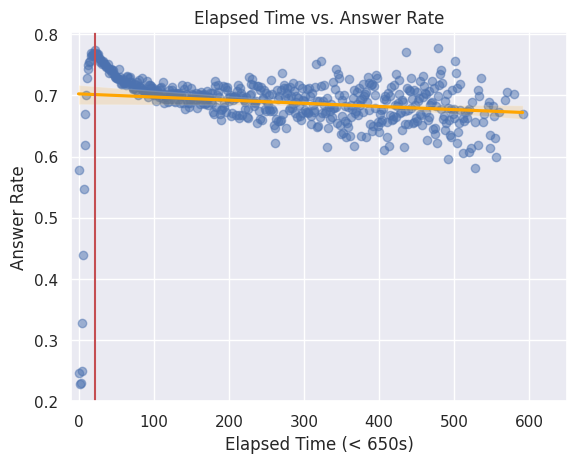

In [38]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)

In [39]:
df.describe()

,userID,answerCode,KnowledgeTag,hour,wd,elapsed
count,2.266586e+06,2.266586e+06,2.266586e+06,2.266586e+06,2.266586e+06,2.266586e+06
mean,2.087687e+03,6.543784e-01,4.909007e+03,8.167683e+00,2.476544e+00,3.293607e+02
std,1.589365e+03,4.755706e-01,3.302214e+03,5.942017e+00,1.704257e+00,6.314168e+02
min,0.000000e+00,0.000000e+00,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+02,0.000000e+00,1.931000e+03,4.000000e+00,1.000000e+00,1.300000e+01
50%,1.748000e+03,1.000000e+00,5.258000e+03,7.000000e+00,2.000000e+00,3.700000e+01
75%,3.046000e+03,1.000000e+00,7.913000e+03,1.100000e+01,4.000000e+00,1.350000e+02
max,7.441000e+03,1.000000e+00,1.127100e+04,2.300000e+01,6.000000e+00,1.800000e+03


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int16         
 6   hour              int64         
 7   wd                int64         
 8   Bigcat            object        
 9   test_paper        object        
 10  problem_id        object        
 11  elapsed           float64       
dtypes: datetime64[ns](1), float64(1), int16(2), int64(2), int8(1), object(5)
memory usage: 166.4+ MB


<AxesSubplot: >

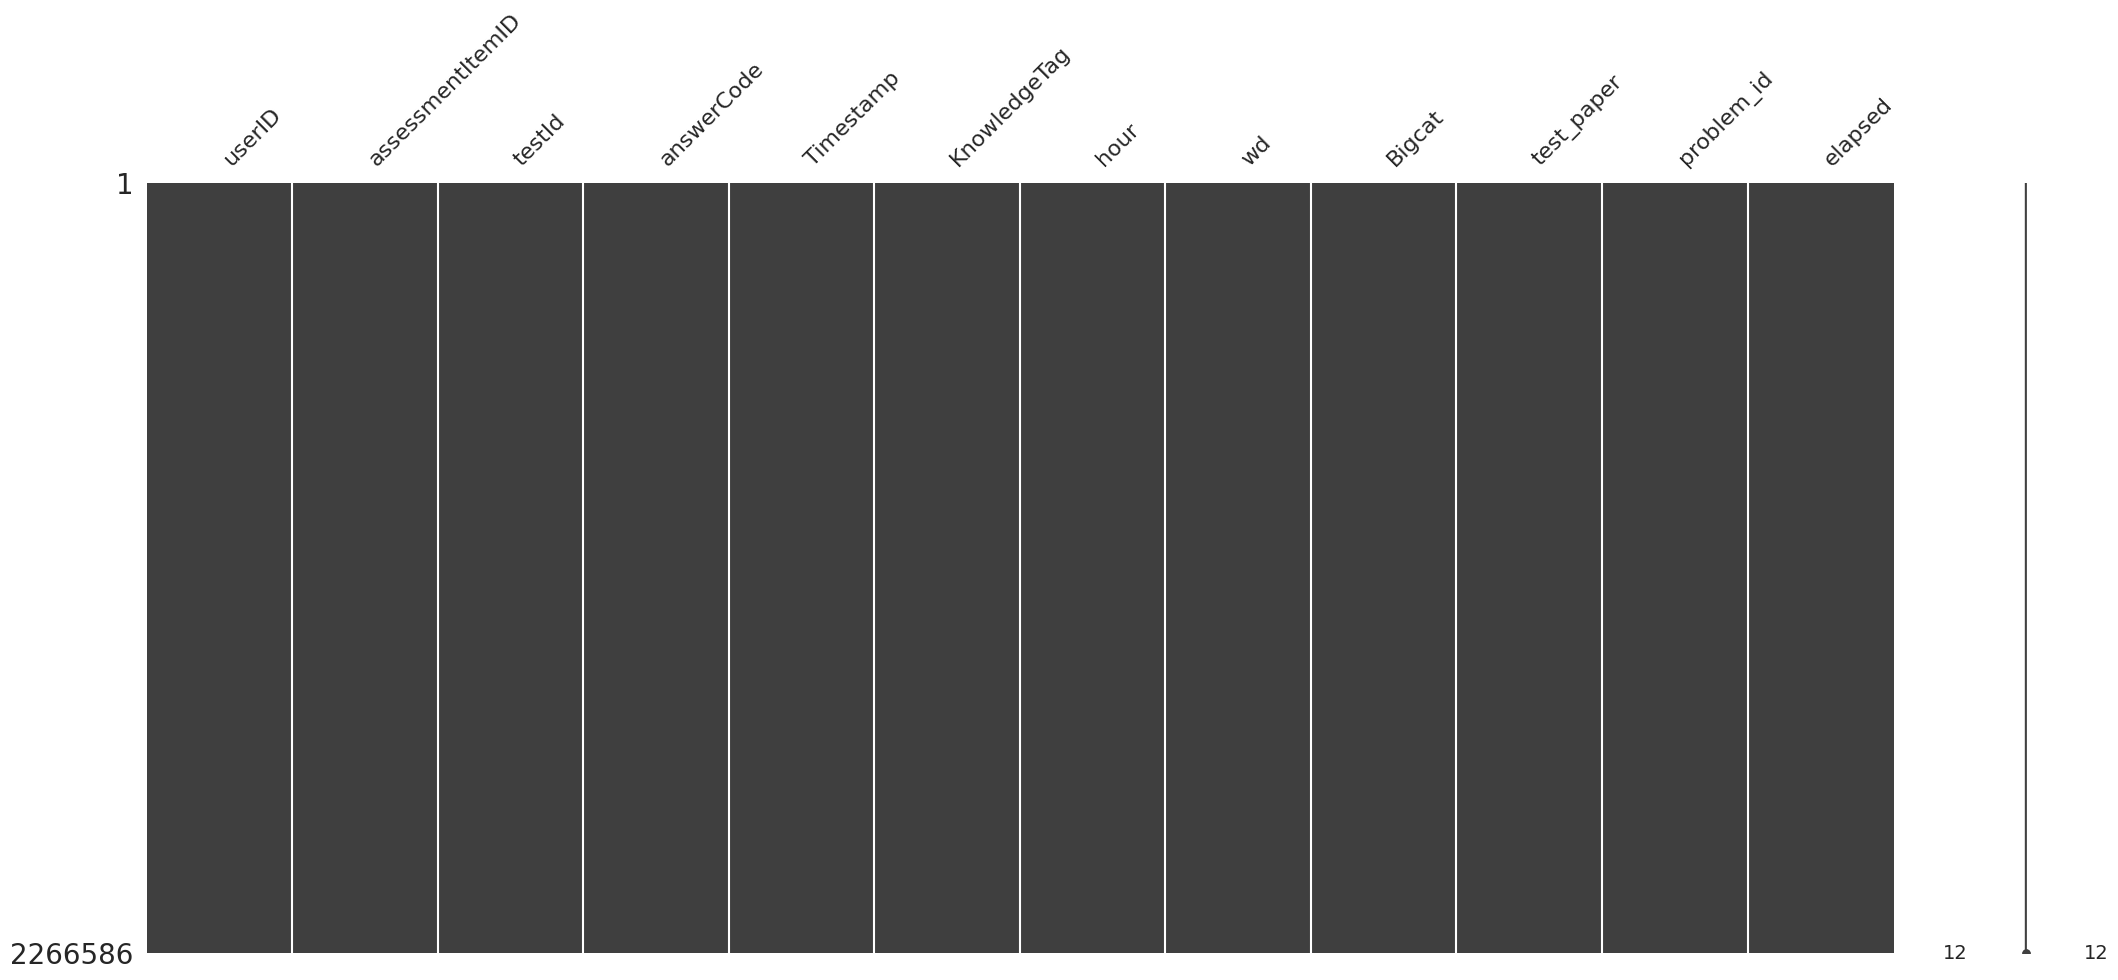

In [41]:
msno.matrix(df)

In [43]:
cat_cols = df[['Bigcat','hour','wd','test_paper','problem_id','answerCode']]
con_cols = df[['Timestamp','KnowledgeTag','elapsed','answerCode']]

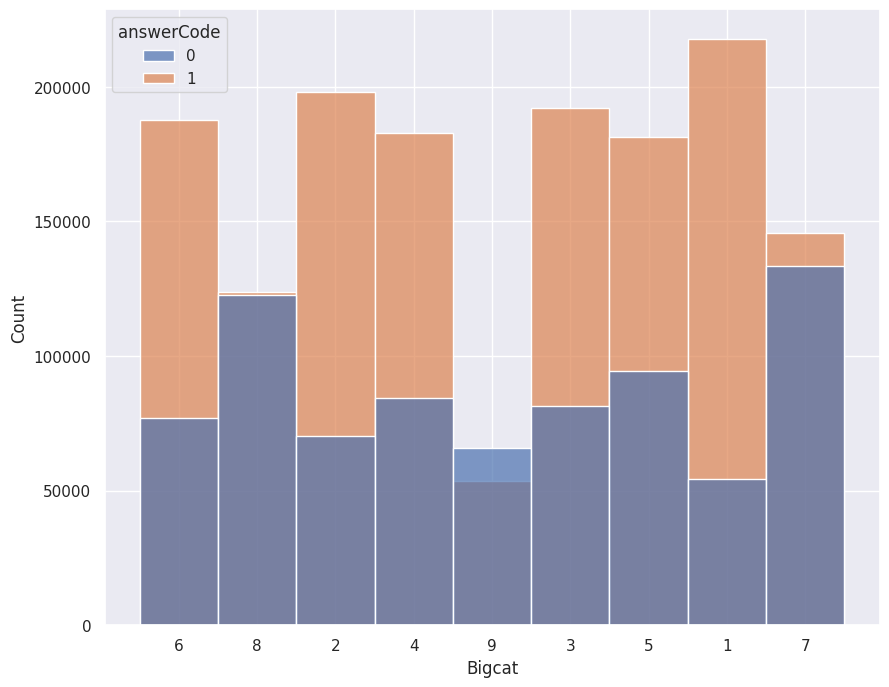

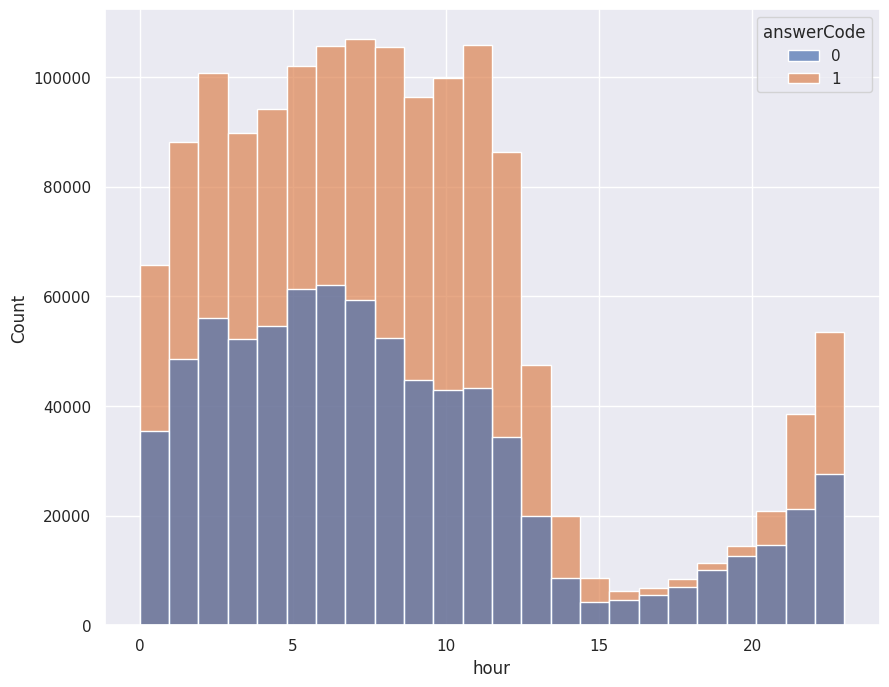

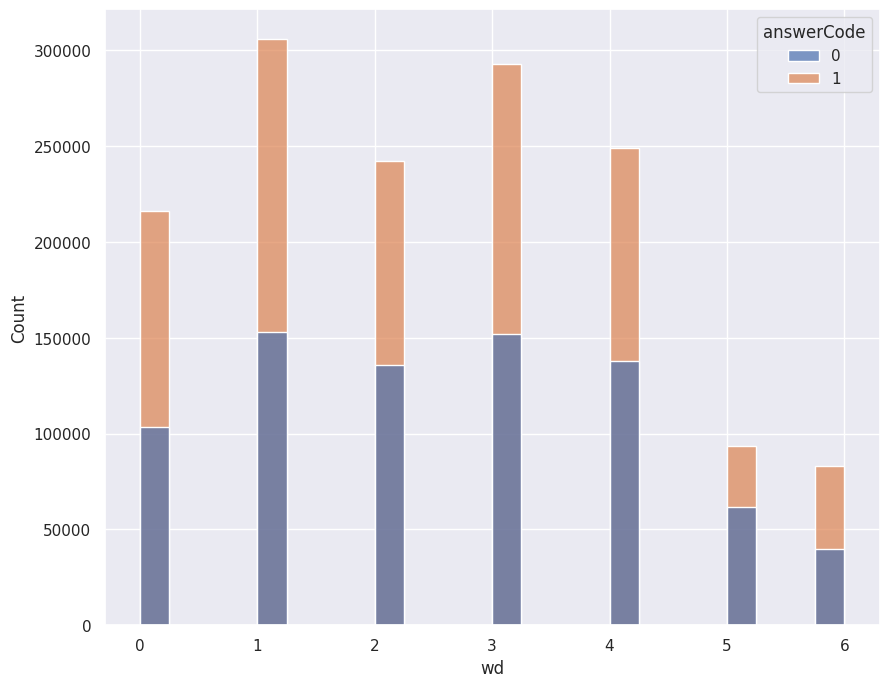

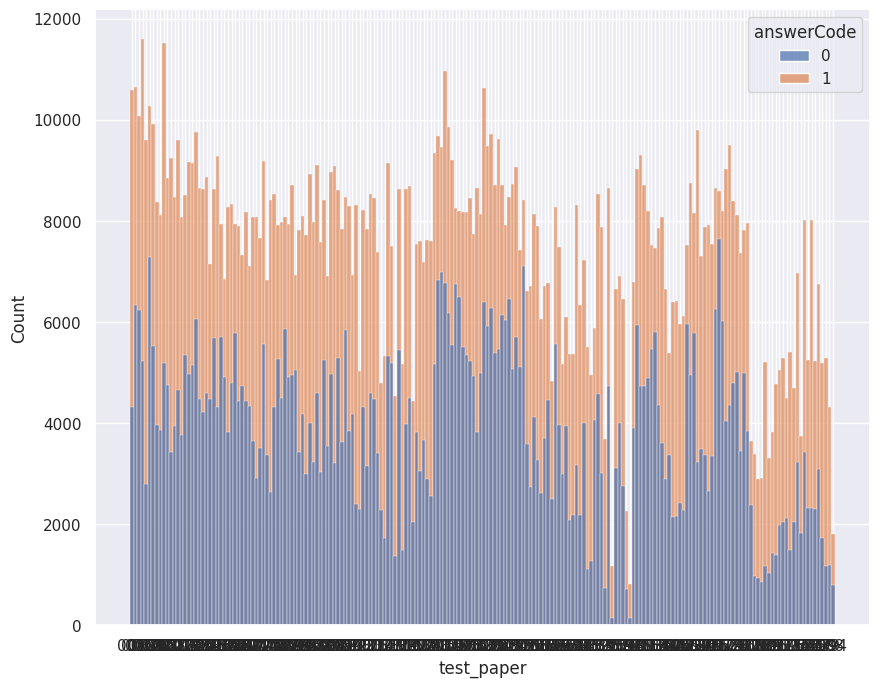

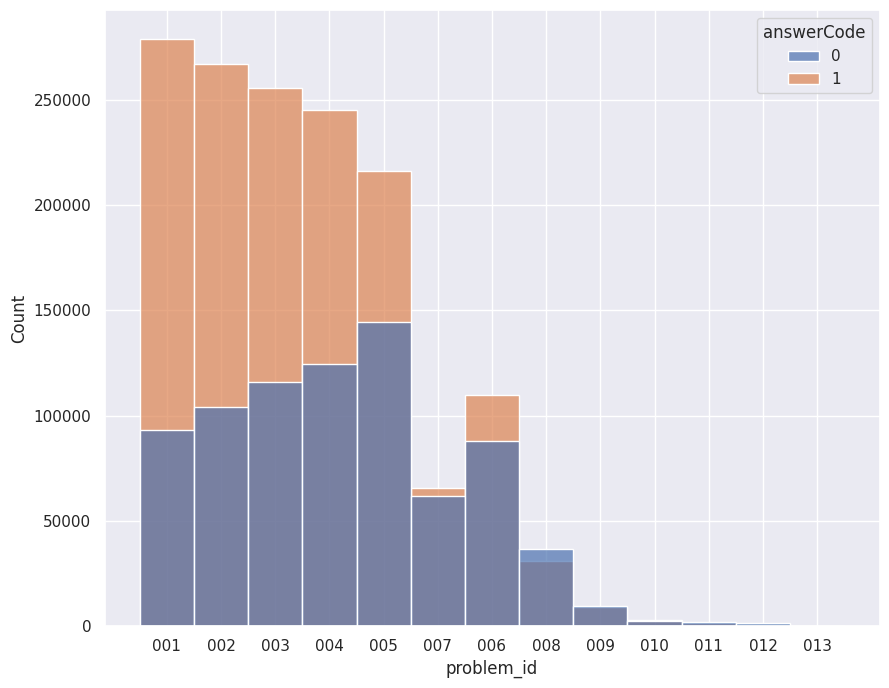

In [44]:
sns.set(rc={'figure.figsize':(10,8)})

for i in cat_cols.columns[:-1]:
    sns.histplot(data=cat_cols, x = i, alpha = .7, bins = 24, hue = 'answerCode')
    plt.show()

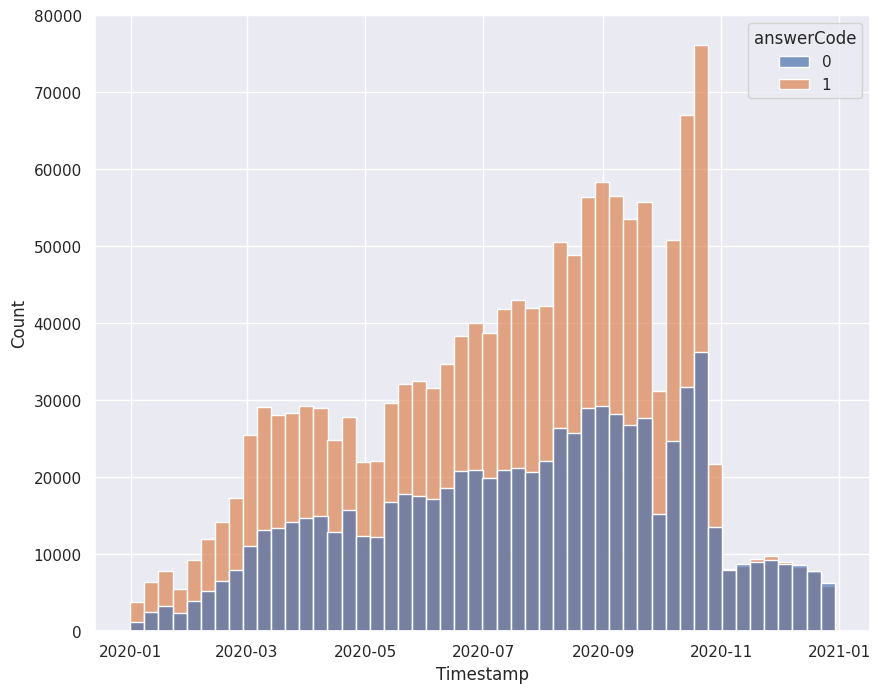

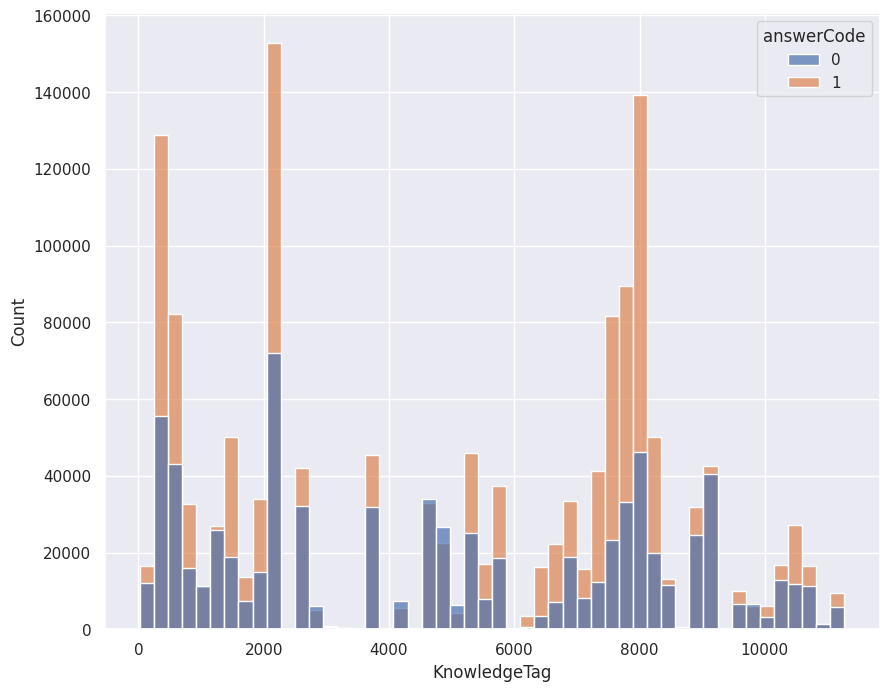

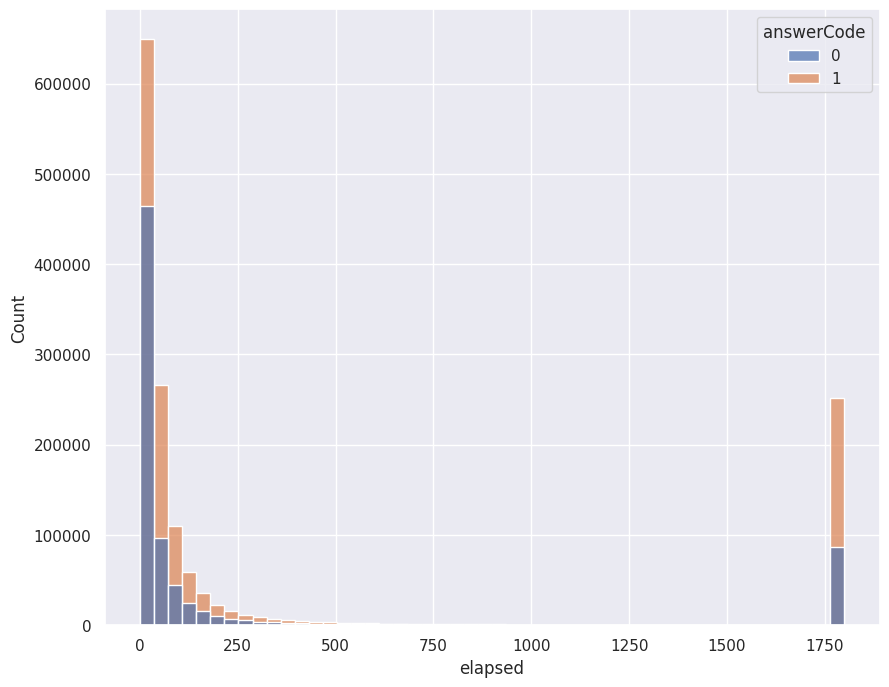

In [45]:
sns.set(rc={'figure.figsize':(10,8)})

for i in con_cols.columns[:-1]:
    sns.histplot(data=con_cols, x = i, alpha = .7, bins = 50, hue = 'answerCode')
    plt.show()